In [133]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
from imblearn.over_sampling import SMOTE
import os
import pickle
import shutil

In [101]:
df = pd.read_csv('df_lr_4.csv')

## Начальные признаки

| Параметр                   | Тип данных       | Описание                                                                 |
|---------------------------|------------------|-------------------------------------------------------------------------|
| **client_id**             | Целое число      | ID клиента (неотрицательное)                                           |
| **Age**                   | Вещественное     | Возраст клиента                                                        |
| **Income**                | Вещественное     | Месячный доход клиента                                                 |
| **BalanceToCreditLimit**  | Вещественное     | Отношение баланса на кредитной карте к лимиту по кредиту               |
| **DIR**                   | Вещественное     | Debt-to-income Ratio (отношение долга к доходу)                        |
| **NumLoans**             | Натуральное число | Число займов и кредитных линий                                        |
| **NumRealEstateLoans**    | Натуральное число | Число ипотек и займов, связанных с недвижимостью                       |
| **NumDependents**         | Натуральное число | Число членов семьи, которых содержит клиент (исключая самого клиента) |
| **Num30-59Delinquencies** | Натуральное число | Число просрочек выплат по кредиту от 30 до 59 дней                     |
| **Num60-89Delinquencies** | Натуральное число | Число просрочек выплат по кредиту от 60 до 89 дней                     |
| **Delinquent90**          | Бинарный         | Таргет: были ли просрочки выплат по кредиту более 90 дней              |


## Добавленные

| Новый признак          | Формула / способ расчёта                                | Что показывает / смысл                                                               |
| ---------------------- | ------------------------------------------------------- | ------------------------------------------------------------------------------------ |
| `DebtBurden`           | `(BalanceToCreditLimit * NumLoans) / Income`            | Отношение долговой нагрузки к доходу; чем выше, тем больше финансовая нагрузка       |
| `DIR_per_Loan`         | `DIR / NumLoans`                                        | Средняя просрочка по каждому кредиту                                                 |
| `TotalDelinquencies`   | `Num30-59Delinquencies + Num60-89Delinquencies`         | Общее количество задолженностей за 30–89 дней                                        |
| `DelinquencyRate`      | `TotalDelinquencies / NumLoans`                         | Доля просрочек относительно общего числа кредитов                                    |
| `Income_per_Dependent` | `Income / (NumDependents + 1)`                          | Доход на одного иждивенца                                                            |
| `Age_Dependent_Ratio`  | `Age / (NumDependents + 1)`                             | Соотношение возраста к числу иждивенцев                                              |
| `RealEstate_Ratio`     | `NumRealEstateLoans / NumLoans`                         | Доля кредитов на недвижимость от общего числа кредитов                               |
| `Loan_Volume_encoded`  | Преобразованная категориальная переменная `Loan_Volume` | Категория по числу кредитов: Single, Few, Many, VeryMany (закодирована числом)       |
| `CreditRiskIndex`      | `(DIR + BalanceToCreditLimit) * DelinquencyRate`        | Индекс кредитного риска с учётом просрочек и долговой нагрузки                       |
| `FinancialStability`   | `Income / (BalanceToCreditLimit * NumLoans)`            | Показатель финансовой устойчивости; чем выше, тем выше способность обслуживать долги |


In [102]:
df

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90,DebtBurden,DIR_per_Loan,TotalDelinquencies,DelinquencyRate,Income_per_Dependent,Age_Dependent_Ratio,RealEstate_Ratio,Loan_Volume_encoded,CreditRiskIndex,FinancialStability
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0,0.000950,0.038176,2,0.153846,5298.360639,49.1,0.000000,3,0.135895,1053.066453
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0,0.000352,0.048174,1,0.111111,2002.685419,16.0,0.222222,3,0.074250,2844.574104
2,2206.731199,55.5,21,1,0.0,1,0,5424.552473,0.348227,0,0.001348,105.082438,1,0.047619,5424.552473,55.5,0.047619,3,105.099020,741.792057
3,886.132793,55.3,3,0,0.0,0,0,5424.552473,0.971930,0,0.000538,295.377598,0,0.000000,5424.552473,55.3,0.000000,0,0.000000,1860.405747
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0,0.000401,0.000000,0,0.000000,2504.613105,52.3,0.000000,2,0.000000,2493.765226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,0.169463,67.6,5,1,0.0,0,0,20129.654428,0.074689,0,0.000019,0.033893,0,0.000000,20129.654428,67.6,0.200000,1,0.000000,53902.594567
74996,2085.662215,43.2,1,1,0.0,0,0,5424.552473,1.005390,0,0.000185,2085.662215,0,0.000000,5424.552473,43.2,1.000000,2,0.000000,5395.470885
74997,0.118935,23.0,4,0,0.0,2,0,2019.117329,0.384511,0,0.000762,0.029734,2,0.500000,2019.117329,23.0,0.000000,1,0.251723,1312.782553
74998,0.203414,46.3,14,2,0.0,0,0,16823.909642,0.524093,0,0.000436,0.014530,0,0.000000,16823.909642,46.3,0.142857,3,0.000000,2292.928605


In [103]:
# Целевая переменная
y = df['Delinquent90']

# Признаки (только числовые)
X = df.drop(columns=['Delinquent90'])

# Разделяем на train/validation/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Размеры выборок:")
print(f"Train: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")


Размеры выборок:
Train: (52500, 19)
Validation: (11250, 19)
Test: (11250, 19)


## Применим SMOTE только к тестовой выборке
что бы избежать утечки данных и что бы оценки на тесте и валидации были приближены к реальным условиям использования модели

In [104]:
# Применяем SMOTE ТОЛЬКО к тренировочным данным
print("До SMOTE:")
print(f"Размер X_train: {X_train.shape}")
print(f"Распределение классов в y_train:")
print(y_train.value_counts())
print(f"Дисбаланс: {y_train.value_counts(normalize=True)}")

# Создаем и применяем SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nПосле SMOTE:")
print(f"Размер X_train_smote: {X_train_smote.shape}")
print(f"Распределение классов в y_train_smote:")
print(y_train_smote.value_counts())
print(f"Баланс: {y_train_smote.value_counts(normalize=True)}")

До SMOTE:
Размер X_train: (52500, 19)
Распределение классов в y_train:
0    48991
1     3509
Name: Delinquent90, dtype: int64
Дисбаланс: 0    0.933162
1    0.066838
Name: Delinquent90, dtype: float64

После SMOTE:
Размер X_train_smote: (97982, 19)
Распределение классов в y_train_smote:
1    48991
0    48991
Name: Delinquent90, dtype: int64
Баланс: 1    0.5
0    0.5
Name: Delinquent90, dtype: float64


## Что бы избежать мультиколлениарности признаков и сократить размерность данных, применим PCA

Заодно посмотрим как SMOTE нагенерировал примеров миноритарного класса

Число компонент для 99% дисперсии: 15
Суммарная объяснённая дисперсия: 0.992


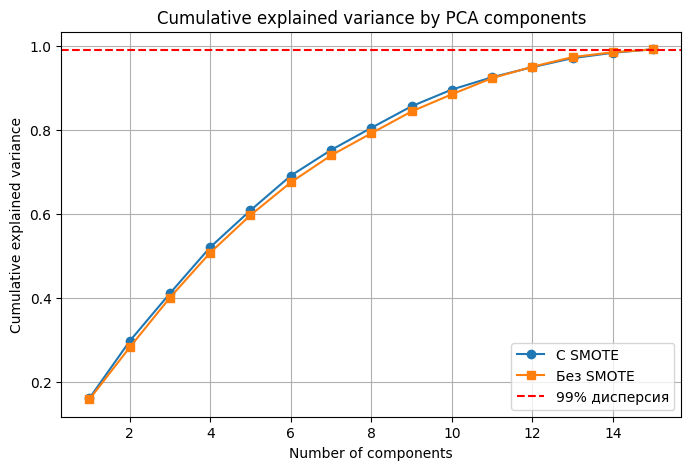

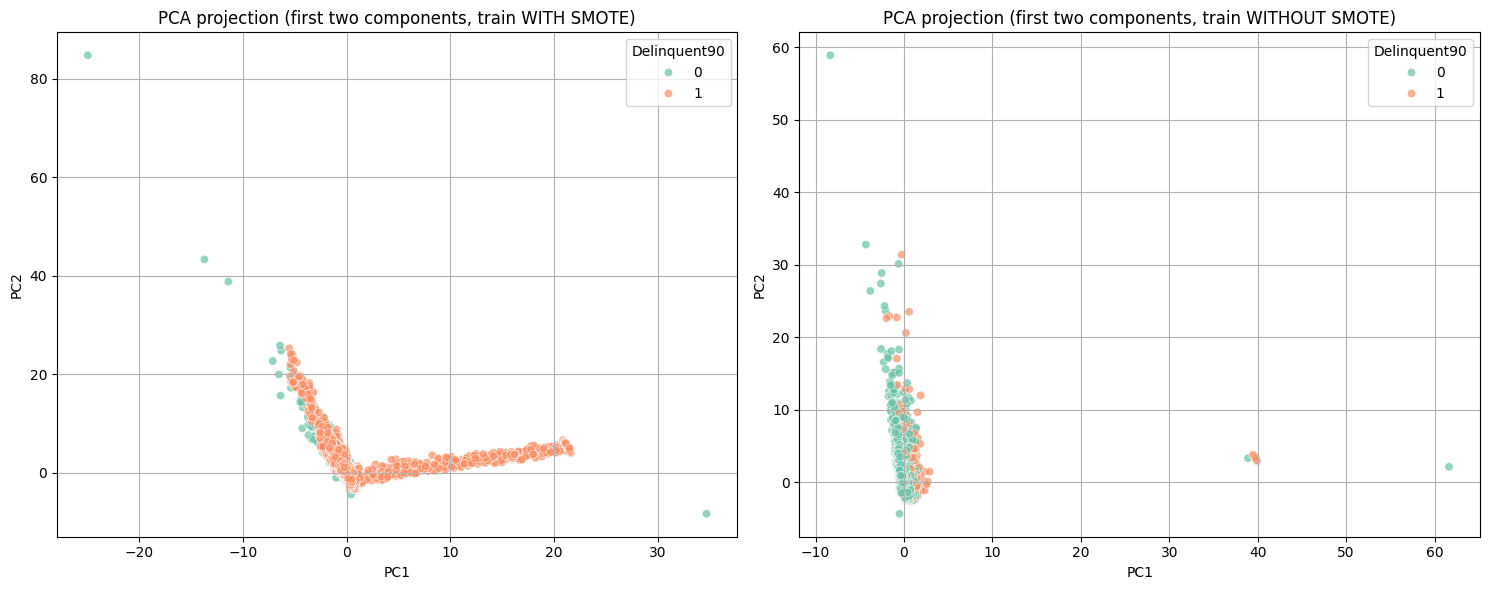

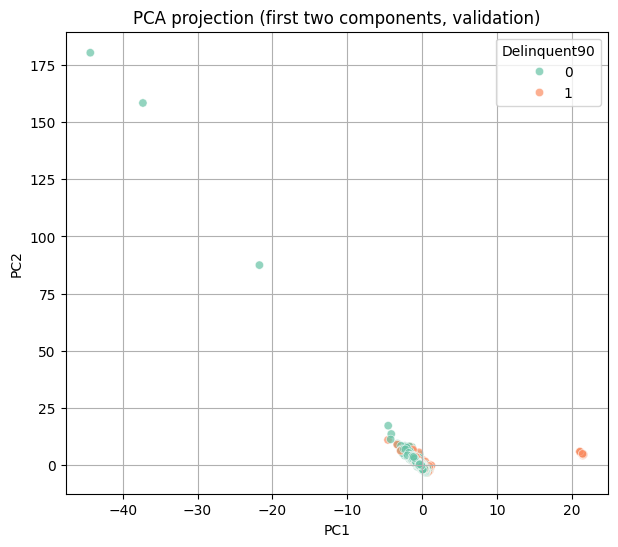

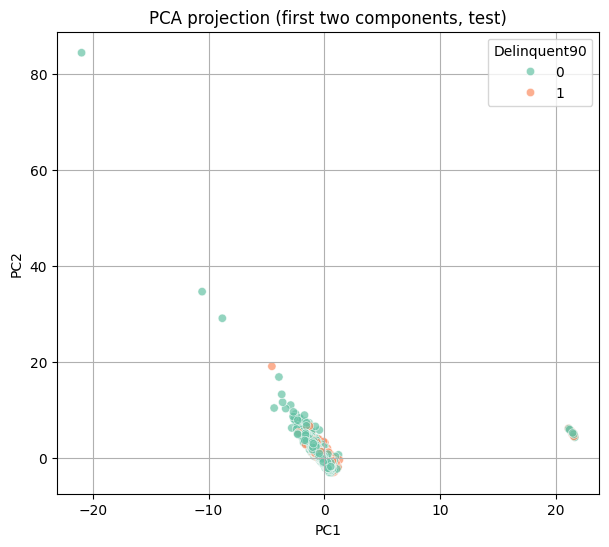

In [105]:

# --- Масштабирование ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_val_scaled = scaler.transform(X_val)  # применяем к validation
X_test_scaled = scaler.transform(X_test)  # применяем к test

# --- PCA до 99% объяснённой дисперсии ---
pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)  # применяем к validation
X_test_pca = pca.transform(X_test_scaled)  # применяем к test

# --- Для наглядности работы SMOTE, PCA на данных без оверсэмплинга ---
# Масштабируем данные без SMOTE
scaler_no_smote = StandardScaler()
X_train_no_smote_scaled = scaler_no_smote.fit_transform(X_train)

# Применяем PCA к данным без SMOTE
pca_no_smote = PCA(n_components=0.99, random_state=42)
X_train_no_smote_pca = pca_no_smote.fit_transform(X_train_no_smote_scaled)

print(f"Число компонент для 99% дисперсии: {pca.n_components_}")
print(f"Суммарная объяснённая дисперсия: {pca.explained_variance_ratio_.sum():.3f}")

# --- Визуализация кумулятивной дисперсии ---
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(), marker='o', label='С SMOTE')
plt.plot(range(1, len(pca_no_smote.explained_variance_ratio_)+1),
         pca_no_smote.explained_variance_ratio_.cumsum(), marker='s', label='Без SMOTE')
plt.axhline(0.99, color='r', linestyle='--', label='99% дисперсия')
plt.title('Cumulative explained variance by PCA components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.legend()
plt.show()

# --- Визуализация первых двух компонент на train (С SMOTE и БЕЗ SMOTE) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График 1: С SMOTE
pca_df_smote = pd.DataFrame(X_train_pca[:, :2], columns=['PC1', 'PC2'])
pca_df_smote['Delinquent90'] = y_train_smote.values

sns.scatterplot(data=pca_df_smote, x='PC1', y='PC2', hue='Delinquent90', 
                palette='Set2', alpha=0.7, ax=ax1)
ax1.set_title('PCA projection (first two components, train WITH SMOTE)')
ax1.grid(True)

# График 2: Без SMOTE
pca_df_no_smote = pd.DataFrame(X_train_no_smote_pca[:, :2], columns=['PC1', 'PC2'])
pca_df_no_smote['Delinquent90'] = y_train.values

sns.scatterplot(data=pca_df_no_smote, x='PC1', y='PC2', hue='Delinquent90', 
                palette='Set2', alpha=0.7, ax=ax2)
ax2.set_title('PCA projection (first two components, train WITHOUT SMOTE)')
ax2.grid(True)

plt.tight_layout()
plt.show()

# --- Визуализация первых двух компонент на validation ---
pca_val_df = pd.DataFrame(X_val_pca[:, :2], columns=['PC1', 'PC2'])
pca_val_df['Delinquent90'] = y_val.values

plt.figure(figsize=(7,6))
sns.scatterplot(data=pca_val_df, x='PC1', y='PC2', hue='Delinquent90', palette='Set2', alpha=0.7)
plt.title('PCA projection (first two components, validation)')
plt.grid(True)
plt.show()

# --- Визуализация первых двух компонент на test ---
pca_test_df = pd.DataFrame(X_test_pca[:, :2], columns=['PC1', 'PC2'])
pca_test_df['Delinquent90'] = y_test.values

plt.figure(figsize=(7,6))
sns.scatterplot(data=pca_test_df, x='PC1', y='PC2', hue='Delinquent90', palette='Set2', alpha=0.7)
plt.title('PCA projection (first two components, test)')
plt.grid(True)
plt.show()

In [106]:
# Создаём имена компонент
pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]

# Преобразуем массивы в DataFrame
# Для тренировочных данных с SMOTE создаем новые индексы
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
X_train_pca_df.index = range(len(X_train_pca_df))  # новые индексы для SMOTE данных

# Для валидационных и тестовых данных используем исходные индексы
X_val_pca_df = pd.DataFrame(X_val_pca, columns=pca_columns, index=X_test.index)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns, index=X_test.index)

print(f"Размер X_train_pca_df: {X_train_pca_df.shape}")
print(f"Размер X_val_pca_df: {X_val_pca_df.shape}")
print(f"Размер X_test_pca_df: {X_test_pca_df.shape}")
print(f"Индексы X_train_pca_df: от {X_train_pca_df.index.min()} до {X_train_pca_df.index.max()}")
print(f"Индексы X_val_pca_df: от {X_val_pca_df.index.min()} до {X_val_pca_df.index.max()}")

Размер X_train_pca_df: (97982, 15)
Размер X_val_pca_df: (11250, 15)
Размер X_test_pca_df: (11250, 15)
Индексы X_train_pca_df: от 0 до 97981
Индексы X_val_pca_df: от 2 до 74963


## Получаем интерпритацию компонент PCA через начальные признаки

Топ-4 исходных признака для каждой PCA-компоненты:

PC1:
   + TotalDelinquencies        | вклад = 0.549
   + Num60-89Delinquencies     | вклад = 0.549
   + Num30-59Delinquencies     | вклад = 0.548
   - NumLoans                  | вклад = 0.151

PC2:
   + DIR                       | вклад = 0.381
   + DIR_per_Loan              | вклад = 0.345
   + NumRealEstateLoans        | вклад = 0.331
   + Age_Dependent_Ratio       | вклад = 0.296

PC3:
   + DIR_per_Loan              | вклад = 0.420
   + DIR                       | вклад = 0.387
   + CreditRiskIndex           | вклад = 0.368
   - Income_per_Dependent      | вклад = 0.358

PC4:
   + Age_Dependent_Ratio       | вклад = 0.505
   - NumDependents             | вклад = 0.480
   - NumRealEstateLoans        | вклад = 0.393
   - RealEstate_Ratio          | вклад = 0.274

PC5:
   + Income                    | вклад = 0.545
   + Income_per_Dependent      | вклад = 0.543
   - NumLoans                  | вклад = 0.329
   - Loan_Volume_encoded  

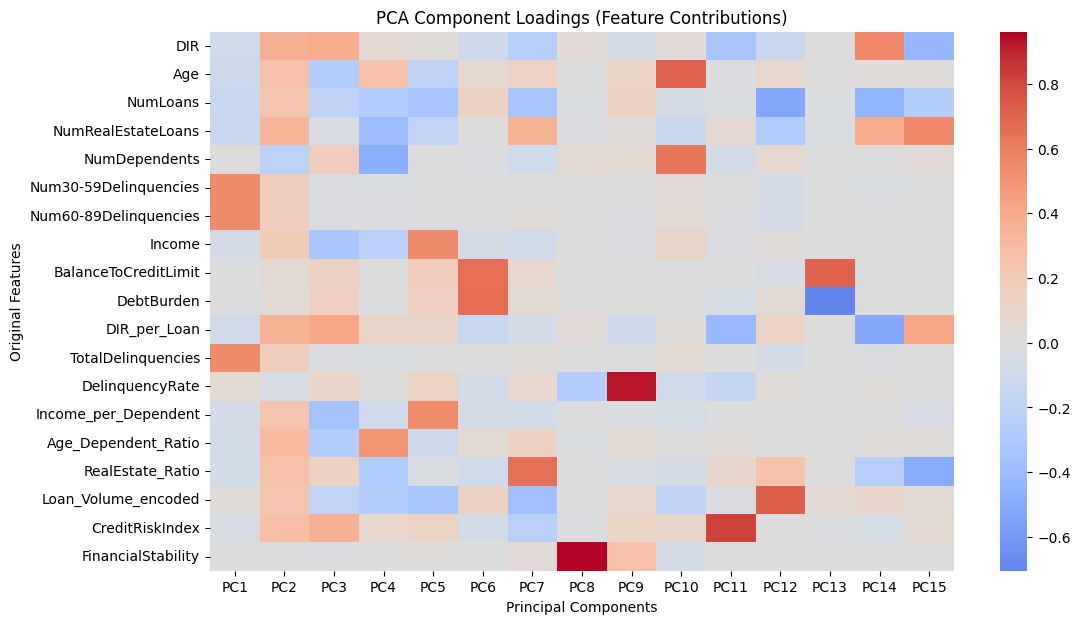

In [107]:
loadings = pd.DataFrame(
    pca.components_.T,           # транспонируем, чтобы строки = признаки
    columns=pca_columns,         # столбцы = PC1, PC2, ...
    index=X.columns              # строки = исходные признаки
)

# === Автоматическая расшифровка компонент ===
print("Топ-4 исходных признака для каждой PCA-компоненты:\n")
for pc in pca_columns:
    top_features = loadings[pc].abs().sort_values(ascending=False).head(4)
    signs = loadings.loc[top_features.index, pc].apply(lambda x: '+' if x > 0 else '-')
    print(f"{pc}:")
    for feat, sign, val in zip(top_features.index, signs, top_features.values):
        print(f"   {sign} {feat:25s} | вклад = {val:.3f}")
    print()

# === Визуализация всех компонент ===
plt.figure(figsize=(12,7))
sns.heatmap(loadings, cmap='coolwarm', center=0)
plt.title('PCA Component Loadings (Feature Contributions)')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()

In [108]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_val_scaled = scaler.transform(X_val_pca)  # применяем к validation
X_test_scaled = scaler.transform(X_test_pca)  # применяем к test

In [109]:
X_train_scaled

array([[-9.36155814e-01,  2.90597054e+00,  2.22226371e+00, ...,
         1.78320036e-02,  3.22412295e+00,  8.42701378e-01],
       [ 9.80406153e-04, -6.43491407e-01,  2.36456112e-01, ...,
         8.53844245e-02, -6.39704945e-02,  2.48640642e-01],
       [-4.26718376e-01,  1.21023881e+00,  2.11878918e+00, ...,
         6.78200535e-02,  1.45790610e+00, -4.59272456e-01],
       ...,
       [-1.80826422e-01,  1.50782537e-01, -6.44289757e-02, ...,
         3.62074902e-02, -8.20801570e-02, -4.38382558e-01],
       [-3.21584849e-01,  3.01086500e-01, -1.69199403e-01, ...,
        -1.08244167e-01, -3.32997821e-01,  6.55317440e-01],
       [-1.27999094e-01,  6.66173398e-01, -9.31908739e-01, ...,
         6.49704499e-03, -8.00921403e-01, -6.98717741e-01]])

In [110]:
X_val_scaled

array([[-0.33254501,  0.88442235,  1.10925687, ...,  0.11586071,
         0.85541353, -0.97890271],
       [-0.45822862,  1.05244667, -1.43819096, ...,  0.01339412,
         0.08443038,  0.29161671],
       [-0.53499535,  1.42915304,  2.65187185, ...,  0.04667577,
        -1.49418397,  0.97227333],
       ...,
       [-0.02948431, -0.11530217, -0.54537325, ...,  0.09912604,
         0.41374953,  0.34377018],
       [-0.18971941,  0.31231176, -0.64585513, ...,  0.04648844,
         0.16600003,  0.15973949],
       [-0.64222904,  2.27961902,  1.61453124, ...,  0.14846964,
         1.6558637 , -1.33867096]])

In [111]:
X_test_scaled

array([[-0.65618671,  1.47020761, -1.12995933, ..., -0.11191883,
         0.3119959 ,  1.79416551],
       [ 0.08890281, -0.5099027 ,  0.33654037, ..., -0.07529415,
         0.0761392 , -0.52060807],
       [-0.21929493,  0.44823269, -0.73662474, ...,  0.05577738,
         0.4483377 ,  0.15364889],
       ...,
       [ 0.16981769, -1.38853293,  0.61284561, ..., -0.0939059 ,
         0.35938544,  0.45040168],
       [-0.54468591,  1.79324312,  0.60140792, ...,  0.10397953,
         0.09669268,  0.41011004],
       [ 0.31282545, -1.18085879,  0.53050879, ...,  0.07146554,
         0.92514198,  0.66748413]])

## Оптимизируем под вычисления на видеокарте

- Преобразуем данные в тензоры PyTorch

- Отправляем на GPU

- Создаём небольшую функцию для батчей

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используем устройство: {device}")

# Конвертируем Series в numpy
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train_smote.to_numpy(), dtype=torch.long, device=device)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.long, device=device)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long, device=device)

batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

print("Данные подготовлены и загружены в батчи.")


Используем устройство: cuda
Данные подготовлены и загружены в батчи.


# Данные подготовили, теперь работаем над созданием своей сетки

## LinearLayer
**Полносвязный слой**
- `forward(X)` → `X@W.T + b` - линейное преобразование
- `backward(grad)` - вычисляет ∇W, ∇b и возвращает ∇вход

## ReLU  
**Активация ReLU**
- `forward(X)` → `max(0,X)` - обнуляет отрицательные значения
- `backward(grad)` → пропускает ∇ только через положительные элементы

In [113]:
class LinearLayer:
    def __init__(self, input_dim, output_dim, device):
        std = torch.sqrt(torch.tensor(2.0 / input_dim))
        self.W = torch.randn(output_dim, input_dim, device=device) * std
        self.b = torch.zeros(output_dim, device=device)
        self.device = device
        
        # Градиенты
        self.dW = torch.zeros_like(self.W)
        self.db = torch.zeros_like(self.b)
    
    def forward(self, X):
        self.X = X  # сохраняем для backward
        return X @ self.W.T + self.b
    
    def backward(self, grad_output):
        # градиенты по W и b
        self.dW = grad_output.T @ self.X
        self.db = grad_output.sum(dim=0)
        # градиент по входу
        grad_input = grad_output @ self.W
        return grad_input

class ReLU:
    def forward(self, X):
        self.mask = (X > 0).float()
        return X * self.mask
    
    def backward(self, grad_output):
        return grad_output * self.mask


## softmax(logits)
- **Назначение**: Нормализует logits в вероятности [0,1]
- **Особенности**: Стабильная реализация (вычитание max)

## cross_entropy_loss(probs, y_true, class_weights)
- **Назначение**: Вычисляет кросс-энтропию между предсказаниями и истинными метками
- **Особенности**: Поддержка весов классов

## softmax_backward(probs, y_true)
- **Назначение**: Градиент кросс-энтропии по входу softmax
- **Формула**: `∇ = (probs - one_hot(y_true)) / N`

In [114]:
def softmax(logits):
    # logits: [batch, num_classes]
    exps = torch.exp(logits - torch.max(logits, dim=1, keepdim=True).values)  # для стабильности
    return exps / exps.sum(dim=1, keepdim=True)

def cross_entropy_loss(probs, y_true, class_weights=None):
    N = y_true.shape[0]
    log_probs = -torch.log(probs[torch.arange(N), y_true])
    
    if class_weights is not None:
        # Правильное применение весов - без нормализации
        weights = class_weights[y_true]  # подставляем weight для каждого элемента
        log_probs = log_probs * weights
    
    return log_probs.mean()

def softmax_backward(probs, y_true):
    # градиент кросс-энтропии по входу softmax
    N = y_true.shape[0]
    grad = probs.clone()
    grad[torch.arange(N), y_true] -= 1
    return grad / N

In [115]:
input_dim = X_train_pca.shape[1]
num_classes = 2

# Пересчитываем веса классов более агрессивно
classes, counts = np.unique(y_train_smote, return_counts=True)
freq = counts / counts.sum()

print("Class distribution:")
print(f"Class 0: {counts[0]} samples ({freq[0]:.3f})")
print(f"Class 1: {counts[1]} samples ({freq[1]:.3f})")

# Веса = 1 / freq
class_weights = 1.0 / freq
class_weights = class_weights / class_weights.sum()  # нормализация не обязательна

class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
print("Class weights:", class_weights)

Class distribution:
Class 0: 48991 samples (0.500)
Class 1: 48991 samples (0.500)
Class weights: tensor([0.5000, 0.5000], device='cuda:0')


## Cross_entropy_loss
**Функция потерь кросс-энтропии**
- `forward(probs, y_true, class_weights)` → вычисляет `-log(probs[true_class])`
- **Особенности**: 
  - Численная стабильность (clamp + epsilon)
  - Поддержка весов классов (class_weights)

In [116]:
def cross_entropy_loss(probs, y_true, class_weights=None):
    N = y_true.shape[0]
    
    # Добавляем небольшую константу для численной стабильности
    epsilon = 1e-8
    probs = torch.clamp(probs, epsilon, 1.0 - epsilon)
    
    log_probs = -torch.log(probs[torch.arange(N), y_true])
    
    if class_weights is not None:
        weights = class_weights[y_true]  # подставляем weight для каждого элемента
        log_probs = log_probs * weights
    
    return log_probs.mean()

# Focal_loss
**Focal Loss для дисбаланса классов**
- `forward(probs, y_true, alpha, gamma)` → `-(1-p_t)ᵞ * log(p_t)`
- **Особенности**:
  - `gamma` - фокусируется на сложных примерах
  - `alpha` - веса для балансировки классов
  - Численная стабильность (clamp)

In [117]:
def focal_loss(probs, y_true, alpha=class_weights, gamma=2.0):
    """
    Focal Loss для борьбы с дисбалансом классов
    alpha - веса классов, gamma - фокусирующий параметр
    """
    N = y_true.shape[0]
    
    # Добавляем небольшую константу для численной стабильности
    epsilon = 1e-8
    probs = torch.clamp(probs, epsilon, 1.0 - epsilon)
    
    # Берем вероятности для правильных классов
    p_t = probs[torch.arange(N), y_true]
    
    # Вычисляем focal loss
    focal_term = (1 - p_t) ** gamma
    if alpha is not None:
        weights = alpha[y_true]
        focal_term = focal_term * weights
    
    loss = -focal_term * torch.log(p_t)
    return loss.mean()

# Cross_entropy_loss_with_focal
**Универсальная функция потерь**
- `forward(probs, y_true, class_weights, use_focal, gamma)` → выбирает тип потерь
- **Режимы**:
  - `use_focal=True` → focal_loss
  - `use_focal=False` → cross_entropy_loss

In [118]:
def cross_entropy_loss_with_focal(probs, y_true, class_weights=None, use_focal=True, gamma=2.0):
    if use_focal:
        return focal_loss(probs, y_true, class_weights, gamma)
    else:
        return cross_entropy_loss(probs, y_true, class_weights)

## Find_optimal_threshold
**Поиск оптимального порога классификации**
- `forward(model, val_loader)` → находит порог с лучшим F1 для класса 1
- **Алгоритм**: перебор порогов от 0.05 до 0.5 с шагом 0.02

## Evaluate_model_with_threshold
**Оценка модели с кастомным порогом**
- `forward(model, test_loader, class_weights, threshold)` → вычисляет метрики
- **Метрики**: loss, F1-macro, F1-class1, accuracy, ROC-AUC, recall, precision
- **Выводы**: отчет классификации, матрица ошибок, метрики класса 1

In [119]:
def find_optimal_threshold(model, val_loader):
    """Находим оптимальный порог для классификации на валидационной выборке"""
    all_probs = []
    all_true = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            logits = model.forward(X_batch)
            probs = softmax(logits)
            all_probs.append(probs.cpu().numpy()[:, 1])  # вероятности класса 1
            all_true.append(y_batch.cpu().numpy())
    
    all_probs = np.concatenate(all_probs)
    all_true = np.concatenate(all_true)
    
    # Ищем оптимальный порог по F1-score класса 1
    from sklearn.metrics import f1_score
    best_threshold = 0.5
    best_f1 = 0
    
    for threshold in np.arange(0.05, 0.5, 0.02):
        preds = (all_probs > threshold).astype(int)
        f1_class1 = f1_score(all_true, preds, pos_label=1, zero_division=0)
        if f1_class1 > best_f1:
            best_f1 = f1_class1
            best_threshold = threshold
    
    print(f"Optimal threshold: {best_threshold:.3f} (F1-class1: {best_f1:.4f})")
    return best_threshold

def evaluate_model_with_threshold(model, test_loader, class_weights, threshold=0.5):
    """Оценка модели с кастомным порогом"""
    all_preds = []
    all_true = []
    all_probs = []
    test_loss = 0
    test_samples = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            logits = model.forward(X_batch)
            probs = softmax(logits)
            
            # Применяем кастомный порог для класса 1
            prob_class_1 = probs.cpu().numpy()[:, 1]
            preds = (prob_class_1 > threshold).astype(int)
            
            # Вычисляем loss
            batch_loss = cross_entropy_loss(probs, y_batch, class_weights)
            test_loss += batch_loss.item() * X_batch.shape[0]
            test_samples += X_batch.shape[0]
            
            all_preds.append(preds)
            all_true.append(y_batch.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    # Объединяем результаты
    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)
    all_probs = np.concatenate(all_probs)
    
    # Вычисляем метрики
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
    
    test_loss = test_loss / test_samples
    test_f1 = f1_score(all_true, all_preds, average='macro')
    test_f1_class1 = f1_score(all_true, all_preds, pos_label=1)
    test_accuracy = (all_preds == all_true).mean()
    
    # ROC-AUC для класса 1
    roc_auc = roc_auc_score(all_true, all_probs[:, 1])
    
    print("\n" + "="*60)
    print("ТЕСТИРОВАНИЕ МОДЕЛИ")
    print("="*60)
    print(f"Используемый порог: {threshold:.3f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test F1-macro: {test_f1:.4f}")
    print(f"Test F1-class1: {test_f1_class1:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_true, all_preds, target_names=['Class 0', 'Class 1']))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_true, all_preds)
    print(cm)
    
    # Выводим дополнительные метрики для класса 1
    tn, fp, fn, tp = cm.ravel()
    recall_class1 = tp / (tp + fn)
    precision_class1 = tp / (tp + fp)
    
    print(f"\nClass 1 Metrics:")
    print(f"Recall: {recall_class1:.4f}")
    print(f"Precision: {precision_class1:.4f}")
    print(f"Support: {tp + fn}")
    
    return {
        'test_loss': test_loss,
        'test_f1': test_f1,
        'test_f1_class1': test_f1_class1,
        'test_accuracy': test_accuracy,
        'test_roc_auc': roc_auc,
        'predictions': all_preds,
        'probabilities': all_probs,
        'true_labels': all_true,
        'threshold': threshold,
        'recall_class1': recall_class1,
        'precision_class1': precision_class1
    }

# ModelConfig
**Конфигурация модели**
- `__init__(layer_sizes, lr, lr_decay, lr_decay_epoch, num_epochs, print_every, name)` → настройки обучения
- **Параметры**:
  - `layer_sizes` - архитектура сети
  - `lr` - learning rate
  - `lr_decay` - коэффициент уменьшения lr
  - `lr_decay_epoch` - эпоха уменьшения lr
  - `num_epochs` - количество эпох
  - `print_every` - частота вывода логов

In [120]:
class ModelConfig:
    def __init__(self, 
                layer_sizes,
                lr=0.01,
                lr_decay=0.95,
                lr_decay_epoch=30,
                num_epochs=300,
                print_every=15,
                name="model"):
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.lr_decay = lr_decay
        self.lr_decay_epoch = lr_decay_epoch
        self.num_epochs = num_epochs
        self.print_every = print_every
        self.name = name

## Создаем конфиги моделей

In [121]:
configs = [
    ModelConfig(
        layer_sizes=[input_dim, 256, 128, 64, num_classes],
        lr=0.02,
        lr_decay=0.95,
        lr_decay_epoch=25,
        num_epochs=500,
        print_every=10,
        name="MLP_256x128x64"
    ),
    ModelConfig(
        layer_sizes=[input_dim, 512, 256, 128, 64, num_classes],
        lr=0.015,
        lr_decay=0.96,
        lr_decay_epoch=20,
        num_epochs=600,
        print_every=10,
        name="MLP_512x256x128x64"
    ),
    ModelConfig(
        layer_sizes=[input_dim, 128, 64, num_classes],
        lr=0.025,
        lr_decay=0.94,
        lr_decay_epoch=30,
        num_epochs=500,
        print_every=10,
        name="MLP_128x64"
    )
]

# CustomMLP
**Многослойный перцептрон**
- `__init__(config, device)` → создает слои и активации
- `forward(x)` → последовательно применяет LinearLayer + ReLU
- **Архитектура**: 
  - LinearLayer для всех слоев
  - ReLU между скрытыми слоями
  - Без активации на выходе

In [122]:
class CustomMLP:
    def __init__(self, config, device):
        self.config = config
        self.device = device
        self.name = config.name

        layer_sizes = config.layer_sizes
        self.layers = []
        self.activations = []

        for i in range(len(layer_sizes) - 1):
            inp = layer_sizes[i]
            out = layer_sizes[i+1]

            # === передаём device ===
            layer = LinearLayer(inp, out, device=device)
            self.layers.append(layer)

            if i < len(layer_sizes) - 2:
                self.activations.append(ReLU())

    def forward(self, x):
        out = x
        for i in range(len(self.layers)):
            out = self.layers[i].forward(out)
            if i < len(self.activations):
                out = self.activations[i].forward(out)
        return out

# Compute_loss
**Вычисление потерь на данных**
- `forward(model, data_loader, class_weights)` → средний loss по батчам
- **Особенности**: 
  - Автоматический no_grad режим
  - Взвешивание по class_weights
  - Корректное усреднение по всем весам

In [123]:
def compute_loss(model, data_loader, class_weights):
    """Вычисление loss на данных"""
    total_loss = 0
    total_samples = 0
    
    for X_batch, y_batch in data_loader:
        with torch.no_grad():
            logits = model.forward(X_batch)
            probs = softmax(logits)
            loss = cross_entropy_loss(probs, y_batch, class_weights)
            
            total_loss += loss.item() * X_batch.shape[0]
            total_samples += X_batch.shape[0]
    
    return total_loss / total_samples

## Train_model
**Обучение модели с ранней остановкой**
- `forward(model, train_loader, val_loader, class_weights, use_focal)` → обучает модель
- **Особенности**:
  - Focal/Cross-Entropy loss по выбору
  - L2 регуляризация
  - Learning rate decay
  - Ранняя остановка по F1 класса 1
  - Сохранение лучших весов
  - Мониторинг градиентов

In [124]:
# Модифицируем train_model для использования focal loss
def train_model(model, train_loader, val_loader, class_weights, use_focal=True):
    lr = model.config.lr
    num_epochs = model.config.num_epochs
    print_every = model.config.print_every
    lr_decay = model.config.lr_decay
    lr_decay_epoch = model.config.lr_decay_epoch

    history = {
        'name': model.name,
        'train_loss': [],
        'val_loss': [],
        'val_f1': [],
        'val_f1_class1': [],  # добавим F1 для класса 1
        'grad_norms': [],
        'learning_rates': []
    }
    
    base_patience = 25
    patience = base_patience + len(model.layers) * 5
    
    best_f1 = 0
    patience_counter = 0
    best_weights = None
    best_epoch = 0
    best_model_path = None

    for epoch in range(1, num_epochs + 1):
        if epoch % lr_decay_epoch == 0:
            old_lr = lr
            lr *= lr_decay
            if old_lr != lr:
                print(f"Epoch {epoch}: Learning rate decreased to: {lr:.6f}")
        
        history['learning_rates'].append(lr)

        total_loss = 0
        epoch_grad_norms = []

        l2_lambda = 0.001
        
        # --- TRAIN ---
        model_train_loss = 0
        for X_batch, y_batch in train_loader:
            logits = model.forward(X_batch)
            probs = softmax(logits)

            # Используем focal loss
            if use_focal:
                loss = focal_loss(probs, y_batch, class_weights)
            else:
                loss = cross_entropy_loss(probs, y_batch, class_weights)
            
            # L2 регуляризация
            l2_penalty = 0
            for layer in model.layers:
                l2_penalty += torch.sum(layer.W ** 2)
            
            total_loss_with_l2 = loss + l2_lambda * l2_penalty
            model_train_loss += loss.item() * X_batch.shape[0]
            total_loss += total_loss_with_l2.item() * X_batch.shape[0]

            grad = softmax_backward(probs, y_batch)

            # Backward через все слои
            grad_out = grad
            for i in reversed(range(len(model.layers))):
                grad_out = model.layers[i].backward(grad_out)
                if i > 0:
                    grad_out = model.activations[i-1].backward(grad_out)

            # Добавляем L2 градиент к dW
            for layer in model.layers:
                layer.dW += 2 * l2_lambda * layer.W

            # Собираем нормы градиентов
            batch_grad_norms = [torch.norm(layer.dW).item() for layer in model.layers]
            epoch_grad_norms.append(batch_grad_norms)

            # Update weights
            for layer in model.layers:
                layer.W -= lr * layer.dW
                layer.b -= lr * layer.db
                
                layer.dW.zero_()
                layer.db.zero_()

        avg_grad_norms = np.mean(epoch_grad_norms, axis=0)
        history['grad_norms'].append(avg_grad_norms)

        avg_train_loss = model_train_loss / len(X_train_tensor)
        history['train_loss'].append(avg_train_loss)

        # --- VALIDATION ---
        all_preds, all_true, all_probs = [], [], []
        val_loss = 0
        val_samples = 0

        for X_val_batch, y_val_batch in val_loader:
            with torch.no_grad():
                logits = model.forward(X_val_batch)
                probs = softmax(logits)
                preds = torch.argmax(probs, dim=1)
                
                batch_val_loss = cross_entropy_loss(probs, y_val_batch, class_weights)
                val_loss += batch_val_loss.item() * X_val_batch.shape[0]
                val_samples += X_val_batch.shape[0]

                all_preds.append(preds.cpu().numpy())
                all_true.append(y_val_batch.cpu().numpy())
                all_probs.append(probs.cpu().numpy())

        avg_val_loss = val_loss / val_samples
        history['val_loss'].append(avg_val_loss)
        
        all_preds = np.concatenate(all_preds)
        all_true = np.concatenate(all_true)
        
        val_f1 = f1_score(all_true, all_preds, average='macro')
        val_f1_class1 = f1_score(all_true, all_preds, pos_label=1)
        history['val_f1'].append(val_f1)
        history['val_f1_class1'].append(val_f1_class1)

        # Ранняя остановка по F1 класса 1
        if val_f1_class1 > best_f1 + 0.001:
            best_f1 = val_f1_class1
            best_epoch = epoch
            patience_counter = 0
            
            best_weights = []
            for i, layer in enumerate(model.layers):
                best_weights.append({
                    'W': layer.W.clone().cpu(),
                    'b': layer.b.clone().cpu()
                })
            
            best_model_path = f"best_models/{model.name}_best_epoch_{epoch}_f1class1_{best_f1:.4f}.pkl"
            with open(best_model_path, 'wb') as f:
                pickle.dump({
                    'weights': best_weights,
                    'epoch': epoch,
                    'f1_score_class1': best_f1,
                    'config': model.config,
                    'val_loss': avg_val_loss,
                    'train_loss': avg_train_loss
                }, f)
            
            improved = "*** IMPROVED ***"
            print(f"Модель сохранена: {best_model_path}")
        else:
            patience_counter += 1
            improved = ""

        if epoch % print_every == 0 or epoch == 1 or improved:
            grad_info = " ".join([f"{g:.1e}" for g in avg_grad_norms])
            print(f"[{epoch}/{num_epochs}] train_loss={avg_train_loss:.4f}  val_loss={avg_val_loss:.4f}  val_f1_class1={val_f1_class1:.4f}  grads=[{grad_info}]  patience: {patience_counter}/{patience} {improved}")

        if patience_counter >= patience and epoch > 50:
            print(f"\nEarly stopping at epoch {epoch}")
            print(f"Best F1-class1: {best_f1:.4f} at epoch {best_epoch}")
            
            if best_weights is not None:
                for i, layer in enumerate(model.layers):
                    layer.W = best_weights[i]['W'].to(device)
                    layer.b = best_weights[i]['b'].to(device)
            break

    if epoch == num_epochs and best_weights is not None:
        print(f"\nTraining completed. Best F1-class1: {best_f1:.4f} at epoch {best_epoch}")
        for i, layer in enumerate(model.layers):
            layer.W = best_weights[i]['W'].to(device)
            layer.b = best_weights[i]['b'].to(device)

    return history, best_model_path

## Plot_all_histories
**Визуализация истории обучения**
- `forward(histories)` → строит 2 фигуры с графиками
- **Фигура 1**: Train Loss, Val Loss (2 subplots)
- **Фигура 2**: F1-macro, Gradient Norms, Learning Rates (3 subplots)
- **Особенности**:
  - Отмечает лучшие эпохи на F1
  - Логарифмическая шкала для градиентов и LR
  - Выводит статистику по лучшим моделям

In [125]:
def plot_all_histories(histories):
    # Первая фигура: Train Loss и Val Loss (2 subplots)
    fig1, axes1 = plt.subplots(2, 1, figsize=(20, 12))
    
    # --- Train Loss ---
    for h in histories:
        epochs = np.arange(1, len(h["train_loss"]) + 1)
        axes1[0].plot(epochs, h["train_loss"], label=h["name"], linewidth=2)
    axes1[0].set_title("Train Loss")
    axes1[0].set_xlabel("Эпоха")
    axes1[0].set_ylabel("Loss")
    axes1[0].grid(True)
    axes1[0].legend()

    # --- Val Loss ---
    for h in histories:
        epochs = np.arange(1, len(h["val_loss"]) + 1)
        axes1[1].plot(epochs, h["val_loss"], label=h["name"], linewidth=2)
    axes1[1].set_title("Validation Loss")
    axes1[1].set_xlabel("Эпоха")
    axes1[1].set_ylabel("Loss")
    axes1[1].grid(True)
    axes1[1].legend()

    # Вторая фигура: F1, Gradients, Learning Rates (3 subplots)
    fig2, axes2 = plt.subplots(3, 1, figsize=(20, 18))
    
    # --- F1 ---
    for h in histories:
        epochs = np.arange(1, len(h["val_f1"]) + 1)
        axes2[0].plot(epochs, h["val_f1"], label=h["name"], linewidth=2)
        # Отмечаем лучшую эпоху
        best_epoch = np.argmax(h["val_f1"]) + 1
        best_f1 = np.max(h["val_f1"])
        axes2[0].plot(best_epoch, best_f1, 'ro', markersize=8)
    axes2[0].set_title("Val F1-macro")
    axes2[0].set_xlabel("Эпоха")
    axes2[0].set_ylabel("F1-macro")
    axes2[0].grid(True)
    axes2[0].legend()

    # --- Gradients ---
    for h in histories:
        epochs = np.arange(1, len(h["grad_norms"]) + 1)
        grad_data = np.array(h["grad_norms"])
        for i in range(grad_data.shape[1]):
            axes2[1].plot(epochs, grad_data[:, i], 
                        label=f"{h['name']} L{i+1}", linestyle='--', alpha=0.7)
    axes2[1].set_title("Gradient Norms")
    axes2[1].set_xlabel("Эпоха")
    axes2[1].set_ylabel("Gradient Norm")
    axes2[1].set_yscale('log')
    axes2[1].grid(True)
    axes2[1].legend()

    # --- Learning Rates ---
    for h in histories:
        if 'learning_rates' in h:
            epochs = np.arange(1, len(h["learning_rates"]) + 1)
            axes2[2].plot(epochs, h["learning_rates"], label=h["name"], linewidth=2)
    axes2[2].set_title("Learning Rate")
    axes2[2].set_xlabel("Эпоха")
    axes2[2].set_ylabel("Learning Rate")
    axes2[2].set_yscale('log')
    axes2[2].grid(True)
    axes2[2].legend()

    plt.tight_layout()
    plt.show()

    # Выводим статистику по лучшим моделям
    print("\n" + "="*60)
    print("BEST MODEL STATISTICS:")
    print("="*60)
    for h in histories:
        best_f1 = np.max(h["val_f1"])
        best_epoch = np.argmax(h["val_f1"]) + 1
        final_f1 = h["val_f1"][-1]
        print(f"{h['name']:25} | Best F1: {best_f1:.4f} (epoch {best_epoch}) | Final F1: {final_f1:.4f}")

## Load_model_weights
**Загрузка весов модели**
- `forward(model, weights_path, device)` → загружает сохраненные веса
- **Особенности**:
  - Восстанавливает W и b для всех слоев
  - Выводит информацию об эпохе и F1-score
  - Автоматически переносит на device

In [126]:
def load_model_weights(model, weights_path, device):
    """
    Загрузка сохраненных весов в модель
    """
    with open(weights_path, 'rb') as f:
        saved_data = pickle.load(f)
    
    weights = saved_data['weights']
    
    for i, layer in enumerate(model.layers):
        layer.W = weights[i]['W'].to(device)
        layer.b = weights[i]['b'].to(device)
    
    print(f"Веса загружены из: {weights_path}")
    print(f"Эпоха: {saved_data['epoch']}, F1: {saved_data['f1_score']:.4f}")
    
    return saved_data

## Load_model_weights
**Загрузка весов модели**
- `forward(model, weights_path, device)` → загружает сохраненные веса
- **Особенности**:
  - Восстанавливает W и b для всех слоев
  - Выводит информацию об эпохе и F1-class1
  - Автоматически переносит на device

## Evaluate_model
**Полная оценка модели**
- `forward(model, test_loader, class_weights)` → вычисляет метрики на тестовых данных
- **Метрики**: loss, F1-macro, accuracy, ROC-AUC
- **Особенности**:
  - Автоматический no_grad режим
  - Поддержка бинарной и многоклассовой ROC-AUC
  - Вывод отчета классификации и матрицы ошибок

In [127]:
def load_model_weights(model, weights_path, device):
    """
    Загрузка сохраненных весов в модель
    """
    with open(weights_path, 'rb') as f:
        saved_data = pickle.load(f)
    
    weights = saved_data['weights']
    
    for i, layer in enumerate(model.layers):
        layer.W = weights[i]['W'].to(device)
        layer.b = weights[i]['b'].to(device)
    
    print(f"Веса загружены из: {weights_path}")
    print(f"Эпоха: {saved_data['epoch']}, F1-class1: {saved_data['f1_score_class1']:.4f}")
    
    return saved_data

def evaluate_model(model, test_loader, class_weights):
    """
    Полная оценка модели на тестовой выборке
    """
    # Убираем model.eval() так как у CustomMLP нет этого метода
    # Вместо этого используем torch.no_grad() для отключения вычисления градиентов
    
    all_preds = []
    all_true = []
    all_probs = []
    test_loss = 0
    test_samples = 0
    
    with torch.no_grad():  # отключаем вычисление градиентов
        for X_batch, y_batch in test_loader:
            logits = model.forward(X_batch)
            probs = softmax(logits)
            preds = torch.argmax(probs, dim=1)
            
            # Вычисляем loss
            batch_loss = cross_entropy_loss(probs, y_batch, class_weights)
            test_loss += batch_loss.item() * X_batch.shape[0]
            test_samples += X_batch.shape[0]
            
            all_preds.append(preds.cpu().numpy())
            all_true.append(y_batch.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    # Объединяем результаты
    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)
    all_probs = np.concatenate(all_probs)
    
    # Вычисляем метрики
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
    
    test_loss = test_loss / test_samples
    test_f1 = f1_score(all_true, all_preds, average='macro')
    test_accuracy = (all_preds == all_true).mean()
    
    # ROC-AUC для класса 1
    if len(np.unique(all_true)) == 2:
        roc_auc = roc_auc_score(all_true, all_probs[:, 1])
    else:
        roc_auc = roc_auc_score(all_true, all_probs, multi_class='ovo')
    
    print("\n" + "="*60)
    print("ТЕСТИРОВАНИЕ МОДЕЛИ")
    print("="*60)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test F1-macro: {test_f1:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_true, all_preds, target_names=['Class 0', 'Class 1']))
    print("\nConfusion Matrix:")
    print(confusion_matrix(all_true, all_preds))
    
    return {
        'test_loss': test_loss,
        'test_f1': test_f1,
        'test_accuracy': test_accuracy,
        'test_roc_auc': roc_auc,
        'predictions': all_preds,
        'probabilities': all_probs,
        'true_labels': all_true
    }

## Compare_models
**Сравнение моделей по метрикам**
- `forward(histories)` → выводит сравнительную таблицу
- **Сравнивает**: 
  - Val F1-class1 и эпоху
  - Test F1-class1, Recall, AUC (если есть)
- **Особенности**:
  - Сортировка по test/val F1-class1
  - Подсветка лучших результатов

In [128]:
def compare_models(histories):
    """
    Сравнение всех моделей по лучшим результатам
    """
    print("\n" + "="*70)
    print("СРАВНЕНИЕ МОДЕЛЕЙ")
    print("="*70)
    
    results = []
    for h in histories:
        best_val_f1_class1 = np.max(h['val_f1_class1']) if 'val_f1_class1' in h else 0
        best_epoch = np.argmax(h['val_f1_class1']) + 1 if 'val_f1_class1' in h else 0
        
        if 'test_results' in h:
            test_f1 = h['test_results']['test_f1']
            test_f1_class1 = h['test_results']['test_f1_class1']
            test_auc = h['test_results']['test_roc_auc']
            recall_class1 = h['test_results']['recall_class1']
        else:
            test_f1 = None
            test_f1_class1 = None
            test_auc = None
            recall_class1 = None
            
        results.append({
            'name': h['name'],
            'best_val_f1_class1': best_val_f1_class1,
            'best_epoch': best_epoch,
            'test_f1': test_f1,
            'test_f1_class1': test_f1_class1,
            'test_auc': test_auc,
            'recall_class1': recall_class1
        })
    
    # Сортируем по test_f1_class1 (если доступно) или по val_f1_class1
    results.sort(key=lambda x: x['test_f1_class1'] if x['test_f1_class1'] is not None else x['best_val_f1_class1'], reverse=True)
    
    for i, res in enumerate(results):
        if res['test_f1_class1'] is not None:
            test_info = f"Test F1-class1: {res['test_f1_class1']:.4f}, Recall: {res['recall_class1']:.4f}, AUC: {res['test_auc']:.4f}"
        else:
            test_info = "Not tested"
        print(f"{i+1}. {res['name']:25} | Val F1-class1: {res['best_val_f1_class1']:.4f} (epoch {res['best_epoch']}) | {test_info}")

# Обучение

In [129]:
# Запускаем улучшенное обучение
all_histories = []
best_model_paths = []

for cfg in configs:
    print("\n" + "="*50)
    print(f"Обучаем модель: {cfg.name}")
    print("="*50)

    model = CustomMLP(cfg, device)
    history, best_path = train_model(model, train_loader, val_loader, class_weights, use_focal=True)
    
    all_histories.append(history)
    best_model_paths.append(best_path)



Обучаем модель: MLP_256x128x64
Модель сохранена: best_models/MLP_256x128x64_best_epoch_1_f1class1_0.3345.pkl
[1/500] train_loss=0.0813  val_loss=0.2083  val_f1_class1=0.3345  grads=[2.5e-01 9.9e-01 6.1e-01 3.9e-01]  patience: 0/45 *** IMPROVED ***
Модель сохранена: best_models/MLP_256x128x64_best_epoch_2_f1class1_0.3415.pkl
[2/500] train_loss=0.0760  val_loss=0.1830  val_f1_class1=0.3415  grads=[3.2e-01 1.2e+00 6.1e-01 2.9e-01]  patience: 0/45 *** IMPROVED ***
Модель сохранена: best_models/MLP_256x128x64_best_epoch_3_f1class1_0.3543.pkl
[3/500] train_loss=0.0753  val_loss=0.1680  val_f1_class1=0.3543  grads=[3.7e-01 1.2e+00 6.2e-01 2.6e-01]  patience: 0/45 *** IMPROVED ***
[10/500] train_loss=0.0646  val_loss=0.1674  val_f1_class1=0.3403  grads=[5.0e-01 1.2e+00 4.7e-01 1.3e-01]  patience: 7/45 
[20/500] train_loss=0.0586  val_loss=0.1701  val_f1_class1=0.3285  grads=[7.2e-01 1.3e+00 3.9e-01 7.6e-02]  patience: 17/45 
Epoch 25: Learning rate decreased to: 0.019000
[30/500] train_loss=0

## Строим график

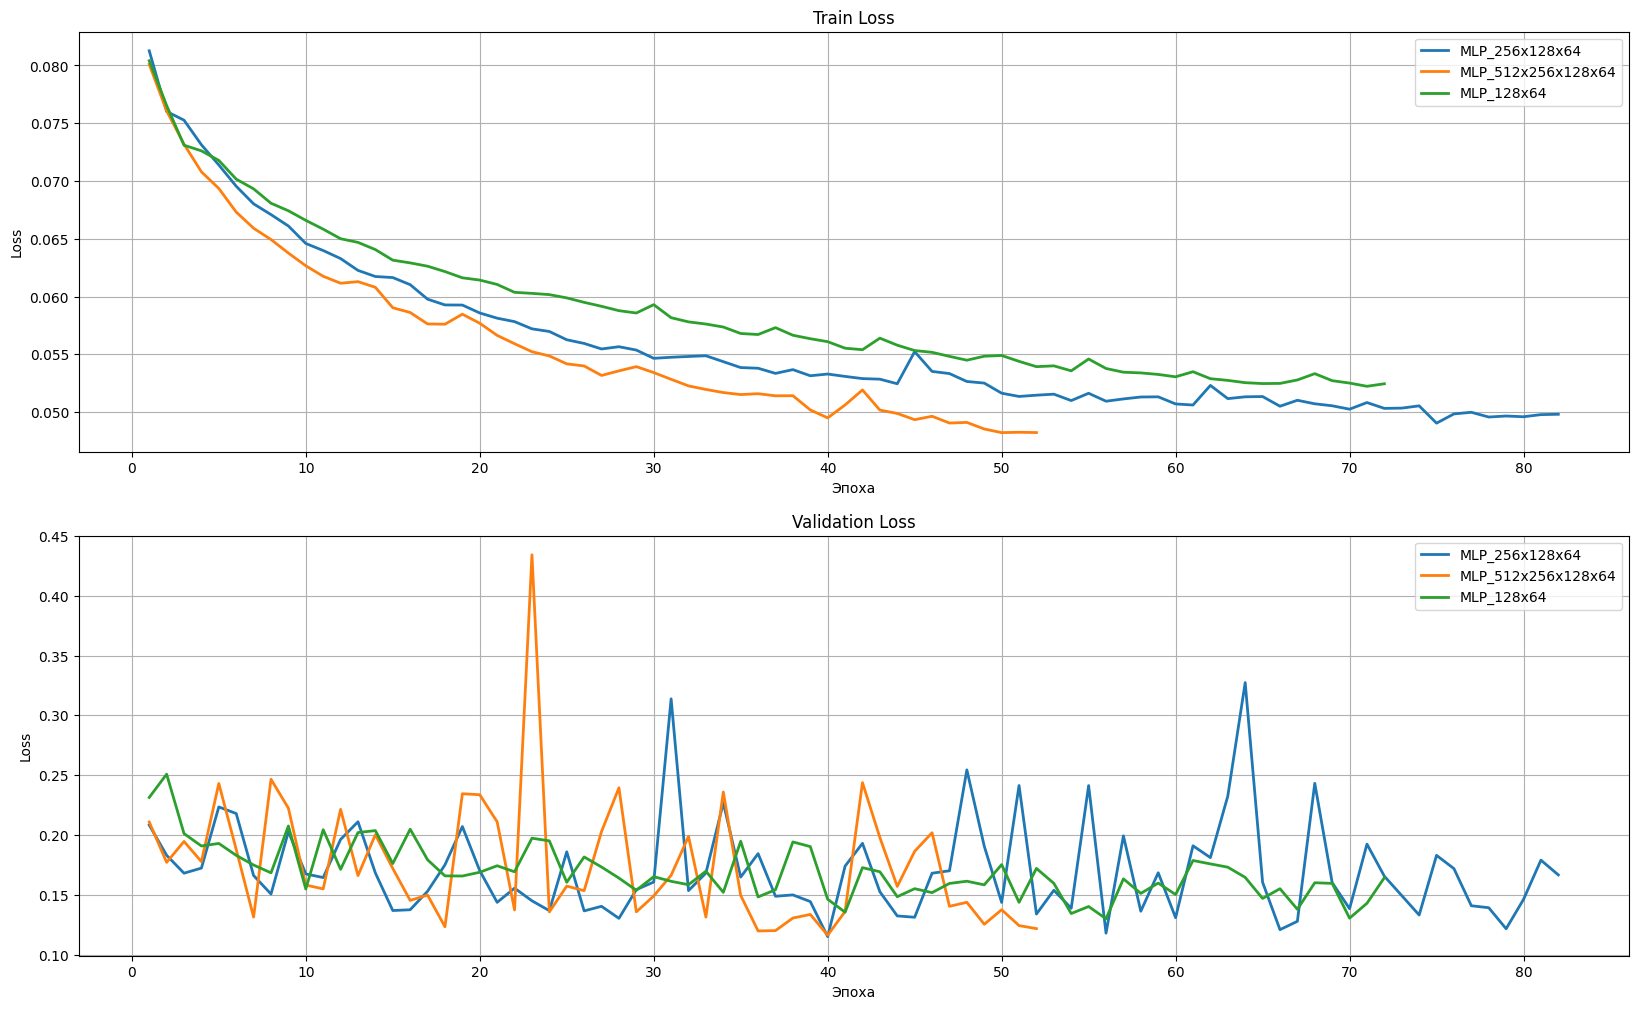

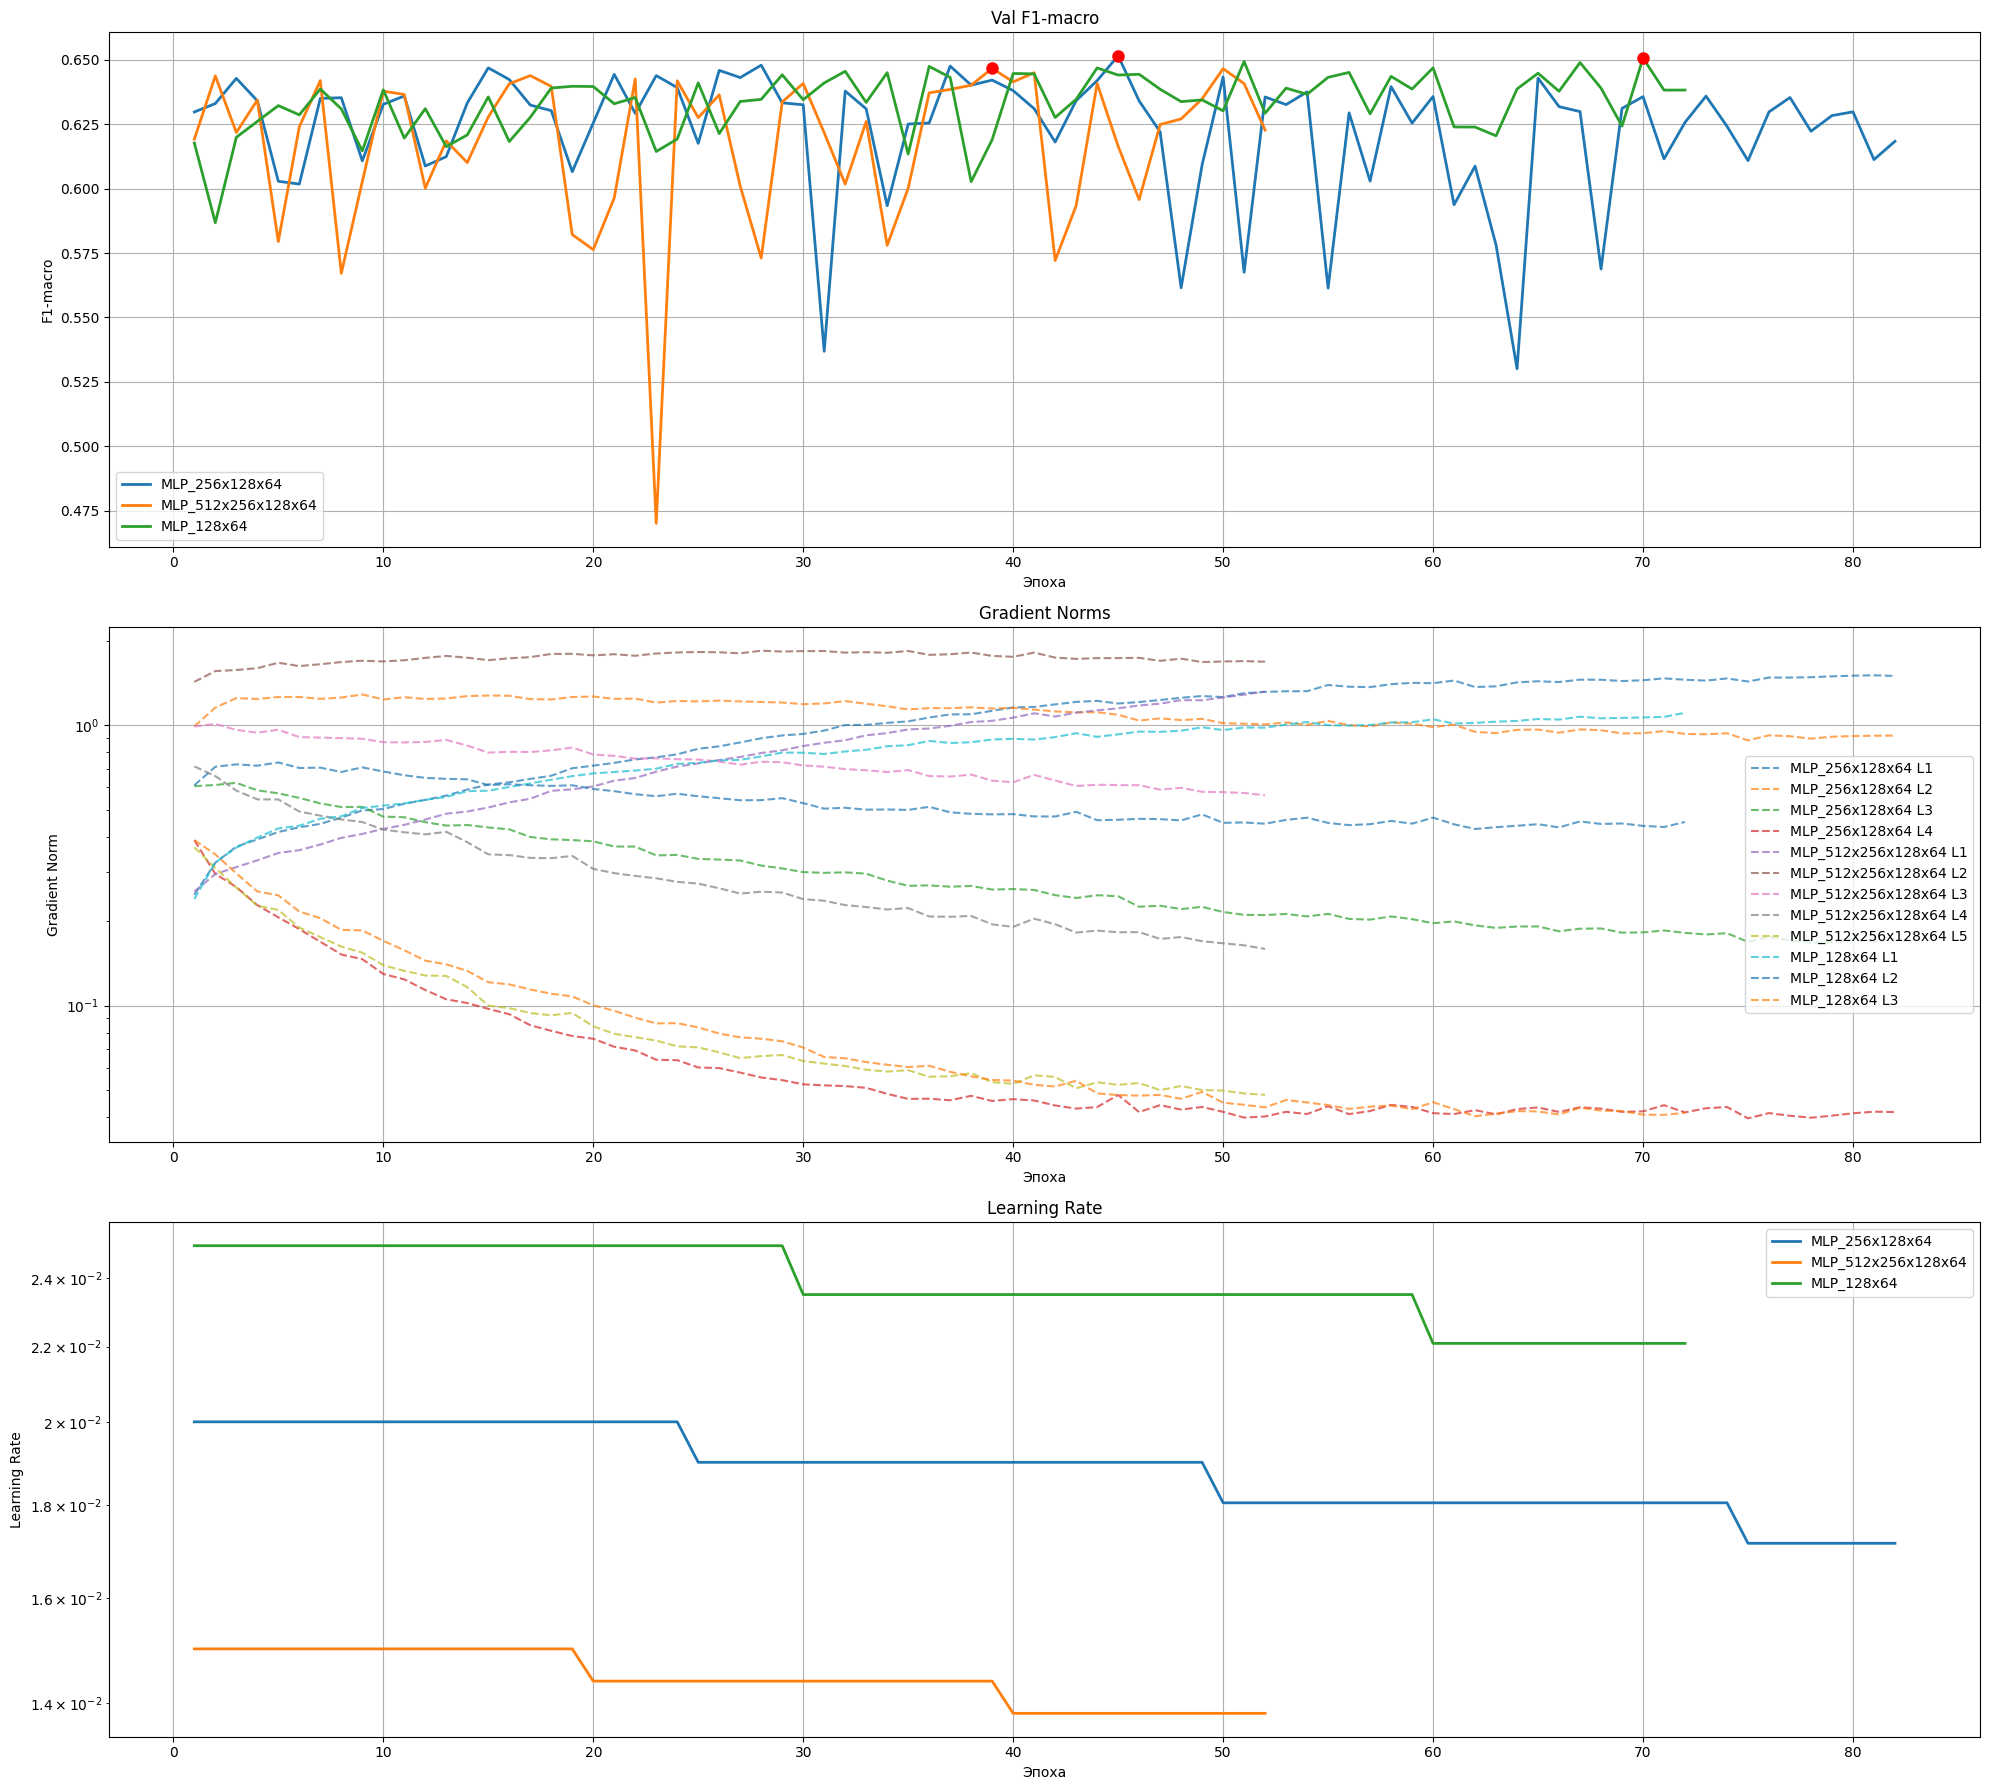


BEST MODEL STATISTICS:
MLP_256x128x64            | Best F1: 0.6516 (epoch 45) | Final F1: 0.6184
MLP_512x256x128x64        | Best F1: 0.6467 (epoch 39) | Final F1: 0.6228
MLP_128x64                | Best F1: 0.6507 (epoch 70) | Final F1: 0.6383


In [130]:
plot_all_histories(all_histories)

# Тестирование с оптимизированными порогами
**Полный пайплайн тестирования**
- `forward()` → тестирует все модели с оптимальными порогами
- **Шаги**:
  1. Загрузка лучших весов для каждой модели
  2. Поиск оптимального порога на валидации
  3. Оценка на тесте с найденным порогом
  4. Сохранение результатов и сравнение моделей

In [131]:
# Тестируем с оптимизированными порогами
print("\n" + "="*60)
print("ТЕСТИРОВАНИЕ С ОПТИМИЗИРОВАННЫМИ ПОРОГАМИ")
print("="*60)

for i, (cfg, model_path) in enumerate(zip(configs, best_model_paths)):
    if model_path:
        print(f"\n--- Тестируем {cfg.name} ---")
        
        test_model = CustomMLP(cfg, device)
        load_model_weights(test_model, model_path, device)
        
        # Находим оптимальный порог на валидационной выборке
        optimal_threshold = find_optimal_threshold(test_model, val_loader)
        
        # Оцениваем на тестовой выборке с оптимальным порогом
        test_results = evaluate_model_with_threshold(test_model, test_loader, class_weights, optimal_threshold)
        
        all_histories[i]['test_results'] = test_results

compare_models(all_histories)


ТЕСТИРОВАНИЕ С ОПТИМИЗИРОВАННЫМИ ПОРОГАМИ

--- Тестируем MLP_256x128x64 ---
Веса загружены из: best_models/MLP_256x128x64_best_epoch_37_f1class1_0.3589.pkl
Эпоха: 37, F1-class1: 0.3589
Optimal threshold: 0.490 (F1-class1: 0.3572)

ТЕСТИРОВАНИЕ МОДЕЛИ
Используемый порог: 0.490
Test Loss: 0.1459
Test F1-macro: 0.6318
Test F1-class1: 0.3309
Test Accuracy: 0.8778
Test ROC-AUC: 0.7949

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.91      0.93     10498
     Class 1       0.26      0.45      0.33       752

    accuracy                           0.88     11250
   macro avg       0.61      0.68      0.63     11250
weighted avg       0.91      0.88      0.89     11250


Confusion Matrix:
[[9535  963]
 [ 412  340]]

Class 1 Metrics:
Recall: 0.4521
Precision: 0.2609
Support: 752

--- Тестируем MLP_512x256x128x64 ---
Веса загружены из: best_models/MLP_512x256x128x64_best_epoch_2_f1class1_0.3578.pkl
Эпоха: 2, F1-class1: 0.3578
Optima

## Лучшая модель
 MLP_128x64                | Val F1-class1: 0.3575 (epoch 36) | Test F1-class1: 0.3325, Recall: 0.4628, AUC: 0.7882

In [134]:
# Выбираем и сохраняем лучшую модель
best_idx = np.argmax([h['test_results']['test_f1_class1'] for h in all_histories])
best_history = all_histories[best_idx]
best_path = best_model_paths[best_idx]

# Создаем папку и копируем модель
os.makedirs('final_best_model', exist_ok=True)
final_path = f"final_best_model/BEST_{best_history['name']}.pkl"
shutil.copy2(best_path, final_path)

print(f"✅ Модель {best_history['name']} сохранена как лучшая (F1-class1: {best_history['test_results']['test_f1_class1']:.4f})")

✅ Модель MLP_128x64 сохранена как лучшая (F1-class1: 0.3325)
